# Digit Recognititon using CNN (Part 2 of Task 2)

Objective:

> Next, select only 0-9 training images from the above dataset, and use the pretrained
network to train on MNIST dataset. Use the standard MNIST train and test splits
(http://yann.lecun.com/exdb/mnist/). How does this pretrained network perform in
comparison to a randomly initialized network in terms of convergence time, final
accuracy and other possible training quality metrics? Do a thorough analysis. Please
save your model checkpoints.

## 1. Importing Libraries
---

In [1]:
import random
import copy
import time 
import pandas as pd 
from PIL import Image

import torch
import torchvision
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
from data import dataset
from plotting import plot_curve, plot_images
from model import Net
from train import train_model, compute_accuracy, cal_accuracy

## 2. Data Preprocessing
---

To change images into vector with normalisation and augmentation, following values are fetched to torchvision.transforms function. We perform: 
    
    - Random Rotations
    - Random Resizing and Cropping 
    - Change Image arrays to Tensor
    - Normalize

In [3]:
train_transforms = transforms.Compose([
                   transforms.RandomRotation(degrees=45),
                   transforms.RandomResizedCrop(64, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
                   transforms.ToTensor(),
                   transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])

               ])

The csv file here is generated from the script. This is for 'dataset' class that we import from data module. The standard splitting ratio, following Yann LeCun's MNIST data is 0.83 as 10000 images were for test and 60000 were for training. Our dataset is very small: only 400 images. Thus we take small batches and try to avoid overfitting and underfitting. 

In [4]:
ROOT = 'data/train'
NEW_LABELS = 'data/digit_labels.csv'
train_numbers = dataset(csv=NEW_LABELS, img_path=ROOT, transform = train_transforms)

VALID_RATIO = 0.83 #Stamdard split according to (http://yann.lecun.com/exdb/mnist/).
n_train_examples = int(len(train_numbers) * VALID_RATIO)
n_valid_examples = len(train_numbers) - n_train_examples
train_num_data, valid_num_data = data.random_split(train_numbers, [n_train_examples, n_valid_examples])

valid_num_data = copy.deepcopy(valid_num_data)
valid_num_data.dataset.transform = train_transforms

print(f'Number of training examples: {len(train_num_data)}')
print(f'Number of validation examples: {len(valid_num_data)}')

Number of training examples: 332
Number of validation examples: 68


In [5]:
train_num_iterator = data.DataLoader(train_num_data, batch_size = 4)
valid_num_iterator = data.DataLoader(valid_num_data, batch_size = 4)

In [6]:
df = pd.read_csv('data/digit_labels.csv')
df.head()

,filenames,labels_code,labels
0,img001-001.png,img001,0
1,img001-002.png,img001,0
2,img001-003.png,img001,0
3,img001-004.png,img001,0
4,img001-007.png,img001,0


Images of 0-9 digits that will fetched to our CNN. Our CNN is inspired by [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).

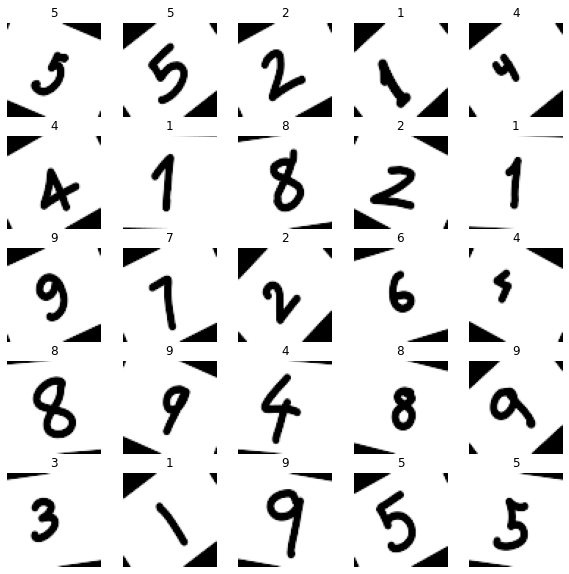

In [7]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in [train_num_data[i] for i in range(N_IMAGES)]])
classes = list(df['labels'].unique())
plot_images(images, labels, classes)

## 3. Pretrained model loading and training 
---

The following model is loaded from training output of the first notebook: [Character Recognition](). In this case we have to train a pretrained model and model intialize from scratch. The pretrained model needs to be modified. The last layer of fully connected layer is changed to 10 output size as there are 10 classes. 

In [8]:
model_trained = Net(62)
model_trained.load_state_dict(torch.load('model.pt'))
model_trained.train()

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

In [9]:
model_trained.classifier[4] = torch.nn.Linear(4096,1024)
model_trained.classifier[6] = torch.nn.Linear(1024,10)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
model_trained.to(device)
criterion_num = torch.nn.CrossEntropyLoss()
optimizer_num = torch.optim.Adam(model_trained.parameters(), lr=1e-4)
device

device(type='cuda')

In [12]:
model_trained

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

In [13]:
train_loss_digits, valid_loss_digits, train_acc_digits, valid_acc_digits = train_model(model=model_trained, #pretrained model from section B.3.
                                             num_epochs=30,
                                             train_iterator=train_num_iterator,
                                             valid_iterator=valid_num_iterator, 
                                             optimizer=optimizer_num,
                                             criterion=criterion_num, 
                                            device=device, 
                                            model_save=False,
                                            model_name="model_1.pt")

Epoch: 1 	Training Loss: 0.576870 	Validation Loss: 0.577592
Epoch: 2 	Training Loss: 0.575965 	Validation Loss: 0.578993
Epoch: 3 	Training Loss: 0.573826 	Validation Loss: 0.577878
Epoch: 4 	Training Loss: 0.562422 	Validation Loss: 0.569286
Epoch: 5 	Training Loss: 0.527614 	Validation Loss: 0.550611
Epoch: 6 	Training Loss: 0.505143 	Validation Loss: 0.530599
Epoch: 7 	Training Loss: 0.460130 	Validation Loss: 0.468651
Epoch: 8 	Training Loss: 0.407412 	Validation Loss: 0.428837
Epoch: 9 	Training Loss: 0.379678 	Validation Loss: 0.350916
Epoch: 10 	Training Loss: 0.328455 	Validation Loss: 0.489230
Epoch: 11 	Training Loss: 0.302059 	Validation Loss: 0.313393
Epoch: 12 	Training Loss: 0.288849 	Validation Loss: 0.238029
Epoch: 13 	Training Loss: 0.241353 	Validation Loss: 0.250470
Epoch: 14 	Training Loss: 0.205721 	Validation Loss: 0.224351
Epoch: 15 	Training Loss: 0.204257 	Validation Loss: 0.190562
Epoch: 16 	Training Loss: 0.159315 	Validation Loss: 0.173611
Epoch: 17 	Traini

**Training and Validation Losses**

## 3.1. Loss Curve

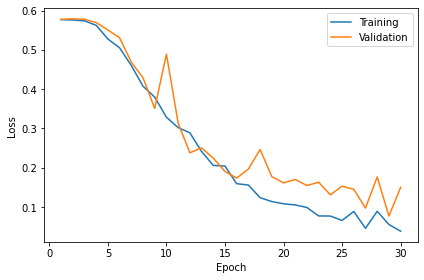

In [14]:
plot_curve(train_loss_digits, valid_loss_digits)

## 3.2. Accuracy Curve

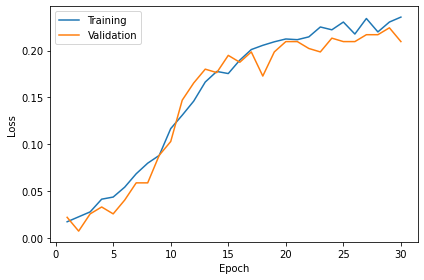

In [15]:
plot_curve(train_acc_digits, valid_acc_digits)

**Training and Validation Accuracy**

In [16]:
cal_accuracy(train_num_iterator, model_trained, device)

Got 311 / 332 with accuracy 93.67


In [17]:
cal_accuracy(valid_num_iterator, model_trained, device)

Got 62 / 68 with accuracy 91.18


## 4. Training model developed from scratch
---

In [18]:
model_digits = Net(10)
model_digits

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

In [19]:
model_digits.to(device)
criterion_digits= torch.nn.CrossEntropyLoss()
optimizer_digits = torch.optim.Adam(model_digits.parameters(), lr=1e-4)
device

device(type='cuda')

In [20]:
tr_loss, val_loss, tr_acc, val_acc = train_model(model=model_digits, #model from scratch 
                                             num_epochs=30,
                                             train_iterator=train_num_iterator,
                                             valid_iterator=valid_num_iterator, 
                                             optimizer=optimizer_digits,
                                             criterion=criterion_digits, 
                                            device=device, 
                                            model_save = False,
                                            model_name="model_2.pt")

Epoch: 1 	Training Loss: 0.577280 	Validation Loss: 0.578835
Epoch: 2 	Training Loss: 0.575653 	Validation Loss: 0.583863
Epoch: 3 	Training Loss: 0.575919 	Validation Loss: 0.586261
Epoch: 4 	Training Loss: 0.575701 	Validation Loss: 0.583019
Epoch: 5 	Training Loss: 0.571226 	Validation Loss: 0.563011
Epoch: 6 	Training Loss: 0.546990 	Validation Loss: 0.565514
Epoch: 7 	Training Loss: 0.514068 	Validation Loss: 0.498702
Epoch: 8 	Training Loss: 0.464559 	Validation Loss: 0.443547
Epoch: 9 	Training Loss: 0.439691 	Validation Loss: 0.414391
Epoch: 10 	Training Loss: 0.384901 	Validation Loss: 0.376838
Epoch: 11 	Training Loss: 0.326139 	Validation Loss: 0.294792
Epoch: 12 	Training Loss: 0.316819 	Validation Loss: 0.295102
Epoch: 13 	Training Loss: 0.265661 	Validation Loss: 0.273668
Epoch: 14 	Training Loss: 0.258822 	Validation Loss: 0.246339
Epoch: 15 	Training Loss: 0.224061 	Validation Loss: 0.265615
Epoch: 16 	Training Loss: 0.213062 	Validation Loss: 0.225016
Epoch: 17 	Traini

## 4.1. Loss Curve

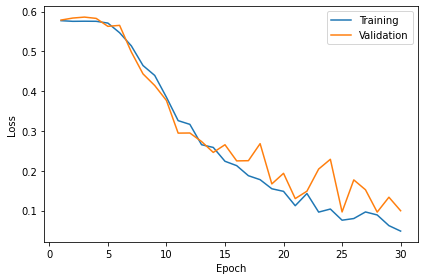

In [21]:
plot_curve(tr_loss, val_loss)

## 4.2. Accuracy Curve

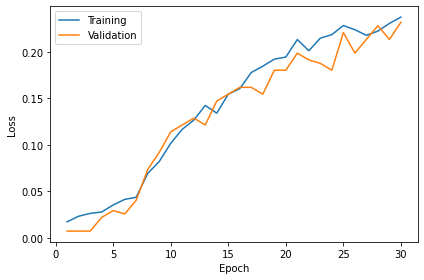

In [22]:
plot_curve(tr_acc, val_acc)

In [23]:
cal_accuracy(train_num_iterator, model_digits, device)


Got 318 / 332 with accuracy 95.78


In [24]:
cal_accuracy(valid_num_iterator, model_digits, device)

Got 63 / 68 with accuracy 92.65


## 5. Conclusion

The pretrained model performs almost similar to the model trained from scratch in predicting the classes. This technique of taking a pretrained model and 'transferring' the knowledge is called **Transfer Learning**. The model converges faster than the model trained from scratch. This can be noticed from the curve of training loss for pretrained model(section 3.2.) being slightly steeper in the case of model from scratch(section 4.2.). 

This performance advanage in pretrained model is because it already has 'knowledge', i.e. pretrained weights than the randomly intialized model from scratch.

# Thank you!

- Author : Pratik Kumar
- Date: April 2021
- Submitted to: MIDAS @IIITD
- References: 

    - [AlexNet Paper](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
    - [MNIST](http://yann.lecun.com/exdb/mnist/)
    - [PyTorch Tutorials](https://pytorch.org/tutorials/)